In [1]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, mean_absolute_error
from scipy.special import softmax, logit

from treeck import DomTree
from treeck.xgb import addtree_from_xgb_model
from treeck.verifier import Verifier, VerifierNotExpr
from treeck.distributed import DistributedVerifier, VerifierFactory
from treeck.z3backend import Z3Backend as Backend

from dask.distributed import Client

import z3

# Load the MNIST dataset

In [2]:
mnist = fetch_openml(data_id=554)

In [3]:
X = mnist.data.astype(float)
y = mnist.target.astype(float)

num_examples = X.shape[0]
num_features = X.shape[1]

np.random.seed(111)
indices = np.random.permutation(num_examples)

m = int(num_examples*0.9)
Itrain = indices[0:m]
Itest = indices[m:]

# Train an XGBoost model

In [ ]:
dtrain = xgb.DMatrix(X[Itrain], y[Itrain], missing=None)
dtest = xgb.DMatrix(X[Itest], y[Itest], missing=None)

params = {
    "objective": "multi:softmax",
    "num_class": 10,
    "tree_method": "hist",
    "max_depth": 6,
    "learning_rate": 0.4,
    "eval_metric": "merror",
    "seed": 10,
}

model = xgb.train(params, dtrain, num_boost_round=200,
                  early_stopping_rounds=5,
                  evals=[(dtrain, "train"), (dtest, "test")])

In [5]:
pred_train = model.predict(dtrain)
pred_test  = model.predict(dtest)

acc_train = accuracy_score(y[Itrain], pred_train)
acc_test  = accuracy_score(y[Itest], pred_test)

print(f"accuracy: train {acc_train*100.0:.1f}%, test {acc_test*100.0:.1f}%")

accuracy: train 100.0%, test 97.2%


# Convert XGBoost trees into treeck's format

XGBoost builds 10 one-versus-all classifiers, one for each digit. It is important to check whether the outputs of the two models correspond. Small errors are due to floating point rounding. If the errors are larger, then most often it is due to an incorrect *base_score* (`at.base_score`).

In [ ]:
def get_addtree(model, digit, N=1000):
    at = addtree_from_xgb_model(model, multiclass=(digit, 10))
    pred_m = model.predict(xgb.DMatrix(X[Itest[:N]]), output_margin=True)[:, digit]
    pred_a = at.predict(X[Itest[:N]])
    mae = mean_absolute_error(pred_m, pred_a)
    print(f"mae model difference {mae:.3g} for digit {digit}")
    return at                                                                                               
                                                                                                              
ats = [get_addtree(model, i, N=100) for i in range(10)]

# Choose an instance to work with

In [7]:
def select_instance():
    index = np.random.randint(0, len(y))
    instance = X[index, :]
    label = y[index]
    return index, instance, int(label)

perturb instance classified as 7 such that it is classified as 9
raw predicted values (before softmax): 7.50, -0.03


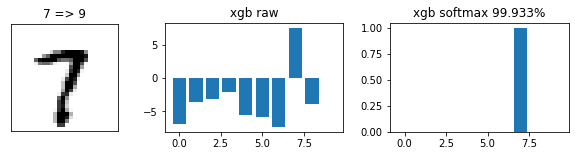

In [10]:
i, instance, source_label = select_instance()
target_labels = list(range(0, source_label)) + list(range(source_label+1, 10))
target_label = np.random.choice(target_labels)

source_pred = ats[source_label].predict_single(instance)
target_pred = ats[target_label].predict_single(instance)
xgb_pred = model.predict(xgb.DMatrix([instance]), output_margin=True)[0]

print(f"perturb instance classified as {source_label} such that it is classified as {target_label}")
print(f"raw predicted values (before softmax): {source_pred:.2f}, {target_pred:.2f}")

fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(10,2), gridspec_kw={'width_ratios': [1.2, 2, 2], 'wspace': 0.3})
ax.imshow(instance.reshape((28, 28)), cmap="binary")
ax.set_yticks([]); ax.set_xticks([])
ax.set_title(f"{source_label} => {target_label}")
ax1.bar(range(10), xgb_pred)
ax1.set_title("xgb raw")
ax2.bar(range(10), softmax(xgb_pred))
ax2.set_title(f"xgb softmax {max(softmax(xgb_pred))*100.0:.3f}%")
plt.show()

# Start a cluster

Execute these two commands in two terminal windows:

- `dask-scheduler --host localhost --port 8786`
- `dask-worker --nthreads 1 --nprocs 3 localhost:8786`

In [11]:
cluster_address = "localhost:8786"

# Question 1: Can we slightly perturb an instance from the dataset such that its predicted label changes?

We first create a `VerifierFactory` instance. This is a recipe for our question. In this factory, we constrain each pixel of the *potential instance* to lie in the interval $[x-\delta, x+\delta]$, where $x$ is the pixel value. We also define a *global budget* $\Delta$, i.e., the sum of all absolute changes (L1) must not be greater than $\Delta$. 

In [12]:
class VFactory1(VerifierFactory):
    def __init__(self, source_instance, offset, maxnorm, model_output):
        self.instance = source_instance
        self.offset = offset
        self.maxnorm = maxnorm
        self.F = model_output

    def __call__(self, lk, check_paths):
        v = Verifier(lk, Backend())
        offs = self.offset
        ctx = v._backend._ctx

        fids_a = set(v.instance(0).feat_ids())
        norm = 0.0

        for i in fids_a:
            x = v.instance(0).xvar(i)
            pixel = self.instance[i]
            v.add_constraint((x > max(0, pixel-offs)) & (x < min(255, pixel+offs)))
            norm += z3.If(x.get()-pixel <= 0, pixel-x.get(), x.get()-pixel)

        v.add_constraint(v.instance(0).fvar() < self.F)

        if not check_paths:
            v.add_constraint(norm < self.maxnorm)

        return v

We can now *execute* the question. We assume a running Dask scheduler at `localhost:8384`.

In [13]:
with Client(cluster_address) as client:
    client.restart()
    addtree = ats[source_label] # pick the relevant 1-vs-all classifier
    domain_constraints = {}     # we don't provide any additional domain constraints
    dt = DomTree(addtree, domain_constraints) # this structure will manage the divide&conquer domain splits

    factory = VFactory1(instance, 75, 3000, logit(0.05))
    dv1 = DistributedVerifier(client, dt, factory,
        check_paths = True,      # enable pruning
        num_initial_tasks = 2,   # we prune and then immediately split into 2 subtasks before solving
        stop_when_num_sats = 2,  # don't stop early
        timeout_start = 60,      # first timeout is 60 seconds
        timeout_grow_rate = 1.5, # second timeout is 90, 135, ...
        global_timeout = 3600    # stop after an hour
    )
    dv1.check()

[0h00m00s    0 0   ] checking paths
[0h00m06s    0 0   ] check_paths(0): [0] -> [530]
[0h00m06s    0 0   ] num_leafs [2016]
[0h00m07s    0 0   ] SPLIT l0: (0, LtSplit(155, 1)) into 1, 2, score 89 
[0h00m08s    1 1   ] SAT for l1 in 0.55s (timeout=60.0s, #leafs=[639])
[0h00m10s    2 0   ] SAT for l2 in 2.03s (timeout=60.0s, #leafs=[598])


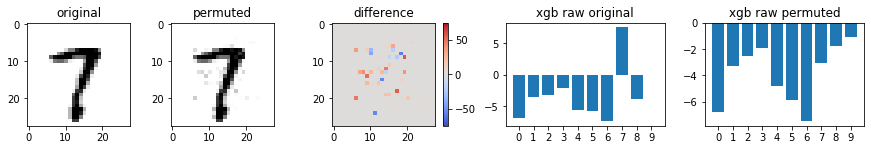

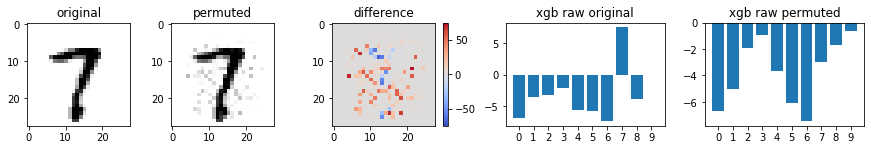

In [14]:
results = [v for k, v in dv1.results.items()
           if isinstance(v, dict)
           and "status" in v
           and v["status"] == Verifier.Result.SAT]

for r in results:
    inst = instance.copy()
    for i, x in r["model"]["xs"].items():
        inst[i] = x
    
    xgb_pred_after = model.predict(xgb.DMatrix([inst]), output_margin=True)[0]
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 1.9), gridspec_kw={'width_ratios': [1.3, 1.3, 1.9, 2, 2], 'wspace': 0.3})
    ax1.imshow(instance.reshape((28,28)), cmap="binary")
    ax1.set_title("original")
    ax2.imshow(inst.reshape((28,28)), cmap="binary")
    ax2.set_title("permuted")
    im = ax3.imshow((inst-instance).reshape((28, 28)), cmap="coolwarm", vmin=-75, vmax=75)
    ax3.set_title("difference")
    ax4.bar(range(10), xgb_pred)
    ax4.set_title("xgb raw original")
    ax4.set_xticks(range(10))
    ax5.bar(range(10), xgb_pred_after)
    ax5.set_title("xgb raw permuted")
    ax5.set_xticks(range(10))
    fig.colorbar(im, ax=ax3)
    plt.show()

# Question 2: Given an instance from the dataset with label $l_1$, can we perturb it such that the model predicts some other label $l_2$?

In [15]:
class VFactory2(VerifierFactory):
    def __init__(self, source_instance, offset, maxnorm, output_value):
        self.instance = source_instance
        self.offset = offset    # \delta
        self.maxnorm = maxnorm  # \Delta
        self.F = output_value

    def __call__(self, lk, check_paths):
        v = Verifier(lk, Backend())
        offs = self.offset
        ctx = v._backend._ctx

        fids_a = set(v.instance(0).feat_ids())
        fids_b = set(v.instance(1).feat_ids())
        norm = 0.0
        
        for i in fids_a.intersection(fids_b):
            v.add_constraint(v.instance(0).xvar(i) == v.instance(1).xvar(i))

        for i in fids_a:
            x = v.instance(0).xvar(i)
            pixel = self.instance[i]
            v.add_constraint((x > max(0, pixel-offs)) & (x < min(255, pixel+offs)))
            norm += z3.If(x.get()-pixel <= 0, pixel-x.get(), x.get()-pixel)

        for i in fids_b.difference(fids_a):
            x = v.instance(1).xvar(i)
            pixel = self.instance[i]
            v.add_constraint((x > max(0, pixel-offs)) & (x < min(255, pixel+offs)))
            norm += z3.If(x.get()-pixel <= 0, pixel-x.get(), x.get()-pixel)
         
        v.add_constraint(v.instance(0).fvar() < self.F)
        v.add_constraint(v.instance(1).fvar() > -self.F)

        if not check_paths:
            v.add_constraint(norm < self.maxnorm)

        return v

In [16]:
with Client(cluster_address) as client:
    client.restart()
    addtree_source = ats[source_label] # pick the 1-vs-all classifier for original label
    addtree_target = ats[target_label] # pick the 1-vs-all classifier for target label
    
    # we now consider two instances of two different 1-vs-all models at once
    dt = DomTree([(addtree_source, {}), (addtree_target, {})])

    factory = VFactory2(instance, 75, 3000, logit(0.05))
    dv2 = DistributedVerifier(client, dt, factory,
        check_paths = True,      # enable pruning
        num_initial_tasks = 2,   # we prune and then immediately split into 2 subtasks before solving
        stop_when_num_sats = 2,  # don't stop early
        timeout_start = 60,      # first timeout is 60 seconds
        timeout_grow_rate = 1.5, # second timeout is 90, 135, ...
        global_timeout = 3600    # stop after an hour
    )
    dv2.check()

[0h00m00s    0 0   ] checking paths
[0h00m17s    0 0   ] check_paths(0): [0, 0] -> [530, 506]
[0h00m17s    0 0   ] num_leafs [2016, 2141]
[0h00m18s    0 0   ] SPLIT l0: (1, LtSplit(128, 8)) into 1, 2, score 95 
[0h00m37s    1 1   ] SAT for l1 in 15.31s (timeout=60.0s, #leafs=[663, 533])
[0h00m52s    2 0   ] SAT for l2 in 30.09s (timeout=60.0s, #leafs=[633, 476])


7 => 9


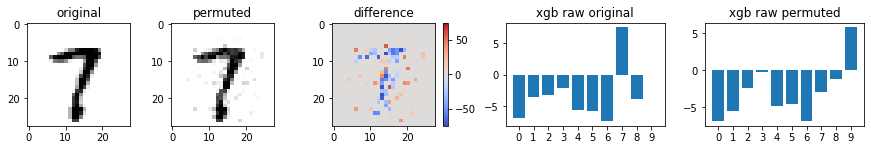

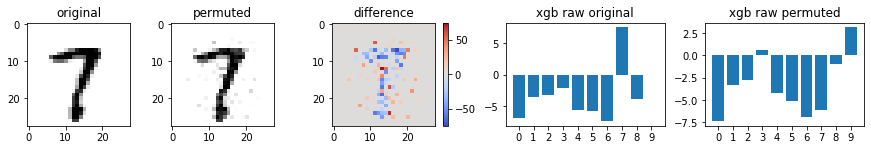

In [17]:
results = [v for k, v in dv2.results.items()
           if isinstance(v, dict)
           and "status" in v
           and v["status"] == Verifier.Result.SAT]

print(source_label, "=>", target_label)

for r in results:
    inst = instance.copy()
    
    for i, x in r["model"][0]["xs"].items():
        inst[i] = x
    for i, x in r["model"][1]["xs"].items():
        inst[i] = x
    
    xgb_pred_after = model.predict(xgb.DMatrix([inst]), output_margin=True)[0]
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 1.9), gridspec_kw={'width_ratios': [1.3, 1.3, 1.9, 2, 2], 'wspace': 0.3})
    ax1.imshow(instance.reshape((28,28)), cmap="binary")
    ax1.set_title("original")
    ax2.imshow(inst.reshape((28,28)), cmap="binary")
    ax2.set_title("permuted")
    im = ax3.imshow((inst-instance).reshape((28, 28)), cmap="coolwarm", vmin=-75, vmax=75)
    ax3.set_title("difference")
    ax4.bar(range(10), xgb_pred)
    ax4.set_title("xgb raw original")
    ax4.set_xticks(range(10))
    ax5.bar(range(10), xgb_pred_after)
    ax5.set_title("xgb raw permuted")
    ax5.set_xticks(range(10))
    fig.colorbar(im, ax=ax3)
    plt.show()